In [800]:
import pandas as pd
import numpy as np
import time
from sklearn.linear_model import LinearRegression

In [801]:
df_proxy = pd.read_csv('..\\models_data\\ibes_eps_semi_annual_by_date_2003_2024.csv')
df = pd.read_csv('..\\models_data\\stock_price_monthly_2003_2024.csv')
df = df.dropna(subset=["past_return", "past_return_skip"])

In [802]:
start_date = '2011-01'
rebalance = 6
end_date_pd = pd.to_datetime(start_date) + pd.DateOffset(months=rebalance)
end_date = end_date_pd.strftime('%Y-%m')
end_date

# Ensure FPEDATS is in datetime format
df_proxy['FPEDATS'] = pd.to_datetime(df_proxy['FPEDATS'])

# Format to 'YYYY-MM' format
df_proxy['FPEDATS'] = df_proxy['FPEDATS'].dt.strftime('%Y-%m')
df_proxy= df_proxy.drop(columns=['Year'])

In [803]:
# Set multi-index on ['date', 'NCUSIP'] and sort for efficient slicing
df = df.set_index(['date', 'NCUSIP'])
df.sort_index(inplace=True)

# Pre-index by date: build a dictionary with date keys for fast lookup in the formation period
dates = df.index.get_level_values('date').unique()
df_by_date = {date: df.loc[date] for date in dates}

VW = False   # Value-weighted flag
SKIP = False # Skip flag
rebalance = 6

In [804]:
# Formation period: retrieve data for the formation period using the pre-indexed dictionary
df1 = df_by_date[start_date].copy()
sort_col = "past_return_skip" if SKIP else "past_return"
df1['rank'] = df1[sort_col].rank(method="first", ascending=False)
# Classify stocks: Winners (top 10%), Losers (bottom 10%), Neutral otherwise
df1['portfolio'] = np.where(
    df1['rank'] <= np.percentile(df1['rank'], 10), 'W',
    np.where(df1['rank'] >= np.percentile(df1['rank'], 90), 'L', 'N')
)
# Select winners and losers portfolios
buy = df1[df1['portfolio'] == 'W'].copy()
sell = df1[df1['portfolio'] == 'L'].copy()

# between start_date and end_date
df_proxy1 = df_proxy[(df_proxy['FPEDATS'] >= start_date) & (df_proxy['FPEDATS'] < end_date)].copy()

In [805]:
print("Buy Index:", buy.index)
print("Sell Index:", sell.index)

Buy Index: Index(['00246W10', '00383010', '00388130', '00430420', '00476410', '00504W10',
       '00520810', '00738A10', '00754E10', '00922R10',
       ...
       '96638710', '96683710', '96759010', '96949010', '98313410', '98414Y10',
       '98884U10', '98885810', '98906R20', '98974P10'],
      dtype='object', name='NCUSIP', length=363)
Sell Index: Index(['00163U10', '00174410', '00202J20', '00484810', '00509L70', '00673910',
       '00760J10', '00817R10', '00826A10', '00827210',
       ...
       '97652A20', '97750V10', '97816610', '98090540', '98256910', '98411C10',
       '98431410', '98878T20', '98974V10', '98976E30'],
      dtype='object', name='NCUSIP', length=363)


In [806]:
buy = buy.reset_index()
sell = sell.reset_index()
buy.sort_values('rank', inplace=True)
buy.head()

,NCUSIP,TICKER,COMNAM,PRC,RET,SHROUT,sprtrn,NasdaqDummy,past_return,past_return_skip,ME,rank,portfolio
86,22148510,CPWM,COST PLUS INC CALIF,8.50,-0.123711,22087.0,0.022646,1,6.083326,7.083322,187739.50,1.0,W
157,44894740,IDT,I D T CORP,23.15,-0.092157,1812.0,0.022646,0,5.412671,6.063635,41947.80,2.0,W
193,50186A10,LGL,L G L GROUP INC,22.01,0.223458,2250.0,0.022646,0,4.502509,3.497505,49522.50,3.0,W
72,16942H10,SHZ,CHINA SHEN ZHOU MINING & RES INC,5.66,-0.326190,30811.0,0.022646,0,4.446496,7.083133,174390.26,4.0,W
158,44894750,IDT,I D T CORP,23.03,-0.102144,17544.0,0.022646,0,4.274912,4.875009,404038.32,5.0,W


In [807]:
# get unqiue NCUSIP and TICKER pairs
_df1 = df1.copy().reset_index()
_df1_unique = _df1[['TICKER', 'NCUSIP']].drop_duplicates()

In [808]:
# Drop FPEDATS and FPI columns if they exist
df_proxy1 = df_proxy1.drop(columns=['FPEDATS', 'FPI'], errors='ignore')

# Merge with df_proxy1 to find missing pairs
merged = _df1_unique.merge(df_proxy1, left_on=['TICKER', 'NCUSIP'], right_on=['OFTIC', 'CUSIP'], how='left', indicator=True)

# Select missing pairs and add them with NUMEST = 0
missing_rows = merged[merged['_merge'] == 'left_only'][['TICKER', 'NCUSIP']]
missing_rows = missing_rows.rename(columns={'TICKER': 'OFTIC', 'NCUSIP': 'CUSIP'})
missing_rows['NUMEST'] = 0

# Append missing rows efficiently
df_proxy1 = pd.concat([df_proxy1, missing_rows], ignore_index=True)

# drop na
df_proxy1 = df_proxy1.dropna(subset=['OFTIC', 'CUSIP'])
df_proxy1

,CUSIP,OFTIC,NUMEST
0,00036020,AAON,24
1,00036110,AIR,151
2,00081T10,ABD,56
3,00086T10,ACMR,45
4,00088630,ADCT,108
...,...,...,...
4158,98388230,XATA,0
4159,98390910,XETA,0
4160,98414Y10,XFN,0
4161,98876R20,ZBB,0


In [809]:
# Ensure columns are strings and properly formatted
df_proxy1['CUSIP'] = df_proxy1['CUSIP'].astype(str).str.zfill(8)
df_proxy1['OFTIC'] = df_proxy1['OFTIC'].astype(str)

_df1['NCUSIP'] = _df1['NCUSIP'].astype(str).str.zfill(8)
_df1['TICKER'] = _df1['TICKER'].astype(str)

# Merge on CUSIP <-> NCUSIP and OFTIC <-> TICKER
df_proxy1 = df_proxy1.merge(
    _df1[['NCUSIP', 'TICKER', 'ME', 'NasdaqDummy']], 
    left_on=['CUSIP', 'OFTIC'], 
    right_on=['NCUSIP', 'TICKER'], 
    how='left'
)

# Drop redundant columns after merge
df_proxy1.drop(columns=['NCUSIP', 'TICKER'], inplace=True)
df_proxy1 = df_proxy1.dropna(subset=['ME'])

# Display result
df_proxy1


,CUSIP,OFTIC,NUMEST,ME,NasdaqDummy
0,00036020,AAON,24,4.445066e+05,1.0
1,00036110,AIR,151,1.062947e+06,0.0
2,00081T10,ABD,56,4.507290e+05,0.0
3,00086T10,ACMR,45,5.561286e+04,1.0
5,00095710,ABM,85,1.353336e+06,0.0
...,...,...,...,...,...
4158,98388230,XATA,0,3.070914e+04,1.0
4159,98390910,XETA,0,3.659080e+04,1.0
4160,98414Y10,XFN,0,2.935330e+04,0.0
4161,98876R20,ZBB,0,2.617285e+04,0.0


In [810]:
# linear regression ln(1+ # of Analyst) = β0​+β1*​ln(Size​)+β2*​NasdaqDummy

# Create a new column with the natural logarithm of the number of analysts
df_proxy1['ln_analysts'] = np.log1p(df_proxy1['NUMEST'])
# Create a new column with the natural logarithm of the market capitalization
df_proxy1['ln_ME'] = np.log(df_proxy1['ME'])


# apply linear regression
X = df_proxy1[['ln_ME', 'NasdaqDummy']]
y = df_proxy1['ln_analysts']
reg = LinearRegression().fit(X, y)
beta0 = reg.intercept_
beta1, beta2 = reg.coef_


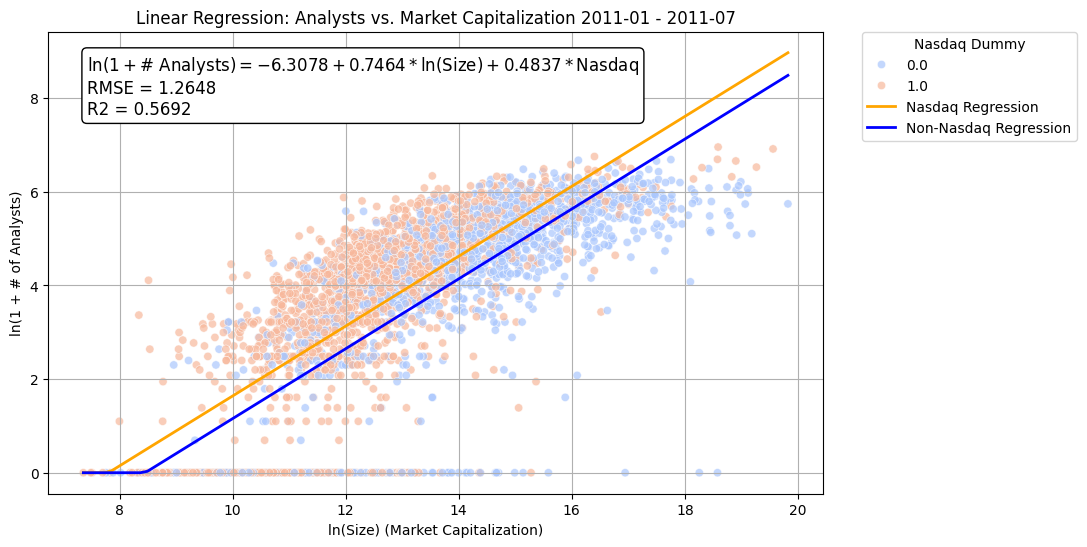

In [811]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score

# Manually compute predicted values and ensure predictions are non-negative
y_pred = reg.predict(X)
y_pred = np.maximum(y_pred, 0)  # Ensure no negative predictions
df_proxy1["predicted_ln_analysts"] = y_pred

# Compute RMSE
rmse = np.sqrt(mean_squared_error(y, y_pred))
r2 = r2_score(y, y_pred)


# Visualization
plt.figure(figsize=(10, 6))

# Scatter plot of actual data points
sns.scatterplot(x=df_proxy1['ln_ME'], y=df_proxy1['ln_analysts'], hue=df_proxy1['NasdaqDummy'], alpha=0.7, palette='coolwarm')

# Regression lines
ln_ME_range = np.linspace(df_proxy1['ln_ME'].min(), df_proxy1['ln_ME'].max(), 100)

# Nasdaq regression line (orange)
ln_analysts_predicted_nasdaq = beta0 + beta1 * ln_ME_range + beta2 * 1  # NasdaqDummy = 1
plt.plot(ln_ME_range, np.maximum(ln_analysts_predicted_nasdaq, 0), color='orange', linewidth=2, label="Nasdaq Regression")

# Non-Nasdaq regression line (blue)
ln_analysts_predicted_non_nasdaq = beta0 + beta1 * ln_ME_range + beta2 * 0  # NasdaqDummy = 0
plt.plot(ln_ME_range, np.maximum(ln_analysts_predicted_non_nasdaq, 0), color='blue', linewidth=2, label="Non-Nasdaq Regression")

# Add Betas & RMSE as text on the plot
textstr = (rf"$\ln(1 + \text{{# Analysts}}) = {beta0:.4f} + {beta1:.4f} * \ln(\text{{Size}}) + {beta2:.4f} * \text{{Nasdaq}}$"
           f"\nRMSE = {rmse:.4f} \nR2 = {r2:.4f}")
plt.text(0.05, 0.95, textstr, transform=plt.gca().transAxes, fontsize=12,
         verticalalignment='top', bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white"))

# Labels and title
plt.xlabel("ln(Size) (Market Capitalization)")
plt.ylabel("ln(1 + # of Analysts)")
plt.title(f"Linear Regression: Analysts vs. Market Capitalization {start_date} - {end_date}")
plt.legend(title="Nasdaq Dummy", loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0)
plt.grid(True)
plt.show()

In [812]:
df_proxy1["predicted_analysts"] = np.expm1(df_proxy1["predicted_ln_analysts"])
df_proxy1["residuals"] = df_proxy1["NUMEST"] - df_proxy1["predicted_analysts"]

df_proxy1.describe()

,NUMEST,ME,NasdaqDummy,ln_analysts,ln_ME,predicted_ln_analysts,predicted_analysts,residuals
count,3626.000000,3.626000e+03,3626.000000,3626.000000,3626.000000,3626.000000,3626.000000,3626.000000
mean,117.048814,3.994865e+06,0.592664,3.727394,13.061485,3.728001,123.636408,-6.587594
std,131.601772,1.690625e+07,0.491406,1.927174,2.050842,1.452199,313.208734,267.428596
min,0.000000,1.570800e+03,0.000000,0.000000,7.359340,0.000000,0.000000,-5461.267647
25%,15.000000,1.052446e+05,0.000000,2.772589,11.564042,2.672859,13.481309,-8.904767
50%,74.000000,4.411623e+05,1.000000,4.317488,12.997168,3.710683,39.881726,10.993963
75%,171.750000,1.936735e+06,1.000000,5.151842,14.476511,4.693229,108.205183,60.346249
max,1049.000000,4.068335e+08,1.000000,6.956545,19.823915,8.774973,6469.267647,506.524287


In [813]:
df_proxy1.sort_values('residuals', ascending=False)

,CUSIP,OFTIC,NUMEST,ME,NasdaqDummy,ln_analysts,ln_ME,predicted_ln_analysts,predicted_analysts,residuals
1403,37940X10,GPN,653,3.768571e+06,0.0,6.483107,15.142206,4.993664,146.475713,506.524287
3060,86765210,SPWRA,566,7.536211e+05,1.0,6.340359,13.532645,4.276085,70.958192,495.041808
3427,92856340,VMW,791,9.980270e+06,0.0,6.674561,16.116121,5.720549,304.072292,486.927708
86,00786510,ARO,524,2.121812e+06,0.0,6.263398,14.567781,4.564939,95.056694,428.943306
170,02553E10,AEO,547,2.829648e+06,0.0,6.306275,14.855663,4.779801,118.080597,428.919403
...,...,...,...,...,...,...,...,...,...,...
2391,68389X10,ORCL,779,1.618290e+08,1.0,6.659294,18.902051,8.283566,3957.282718,-3178.282718
1418,38259P50,GOOG,555,1.506117e+08,1.0,6.320768,18.830216,8.229951,3750.649936,-3195.649936
2110,59491810,MSFT,683,2.329560e+08,1.0,6.527958,19.266360,8.555470,5194.091777,-4511.091777
1190,30231G10,XOM,311,4.068335e+08,0.0,5.743003,19.823915,8.487877,4854.549156,-4543.549156


In [814]:
# # merge residuals col with buy and sell
buy = buy.merge(df_proxy1[['OFTIC', 'CUSIP', 'residuals']], left_on=['NCUSIP', 'TICKER'], right_on=['CUSIP', 'OFTIC'], how='left')
sell = sell.merge(df_proxy1[['OFTIC', 'CUSIP', 'residuals']], left_on=['NCUSIP', 'TICKER'], right_on=['CUSIP', 'OFTIC'], how='left')
buy = buy.drop(columns=['CUSIP', 'OFTIC'], errors='ignore')
sell = sell.drop(columns=['CUSIP', 'OFTIC'], errors='ignore')

# drop rows with NaN residuals
buy = buy.dropna(subset=['residuals'])
sell = sell.dropna(subset=['residuals'])

In [815]:
# long bottom 25% of residual winners
buy['portfolio'] = np.where(
    buy['residuals'] <= np.percentile(buy['residuals'], 25), 'W','N')

# short bottom 25% of residual losers
sell['portfolio'] = np.where(
    sell['residuals'] <= np.percentile(sell['residuals'], 25), 'L','N')

In [816]:
sell.sort_values('residuals', inplace=True)
sell

,NCUSIP,TICKER,COMNAM,PRC,RET,SHROUT,sprtrn,NasdaqDummy,past_return,past_return_skip,ME,rank,portfolio,residuals
71,15343510,CEDC,CENTRAL EUROPEAN DISTRIBUTN CORP,22.94,0.001747,70507.0,0.022646,1,-0.284244,-0.285492,1617430.58,3333.0,L,-119.240561
315,86765230,SPWRB,SUNPOWER CORP,13.20,0.062802,42033.0,0.022646,1,-0.289176,-0.331180,554835.60,3341.0,L,-56.256329
167,40932110,HMPR,HAMPTON ROADS BANKSHARES INC,0.65,0.250000,834675.0,0.022646,1,-0.673367,-0.738694,542538.75,3595.0,L,-55.306536
69,15093450,CTIC,CELL THERAPEUTICS INC,0.35,-0.041096,865922.0,0.022646,1,-0.684684,-0.671171,303072.70,3600.0,L,-31.460090
52,09066L10,BTX,BIOTIME INC,7.83,-0.060024,47596.0,0.022646,0,-0.299168,-0.254415,372676.68,3355.0,L,-25.227101
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
158,38011M10,GMXR,G M X RESOURCES INC,5.22,-0.054348,31283.0,0.022646,0,-0.507082,-0.478754,163297.26,3526.0,N,252.832551
214,60983910,MPWR,MONOLITHIC PWR SYS INC,14.67,-0.111985,35063.0,0.022646,1,-0.288555,-0.198836,514374.21,3340.0,N,262.889752
128,29265910,ENER,ENERGY CONVERSION DEVICES INC,4.08,-0.113043,53274.0,0.022646,1,-0.552631,-0.495614,217357.92,3547.0,N,303.551097
101,20585910,COMV,COMVERGE INC,6.20,-0.102750,25329.0,0.022646,1,-0.368637,-0.296336,157039.80,3417.0,N,335.679401


In [817]:
buy = buy[buy['portfolio'] == 'W']
sell = sell[sell['portfolio'] == 'L']

# Assign weights (equal-weighted or value-weighted)
buy.loc[:, 'weight'] = buy['ME'] / buy['ME'].sum() if VW else 1 / len(buy)
sell.loc[:, 'weight'] = sell['ME'] / sell['ME'].sum() if VW else 1 / len(sell)

buy = buy.set_index("NCUSIP")
sell = sell.set_index("NCUSIP")

C:\Users\vietx\AppData\Local\Temp\ipykernel_32148\189682617.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sell.loc[:, 'weight'] = sell['ME'] / sell['ME'].sum() if VW else 1 / len(sell)


In [818]:
# Retrieve holding period data using multi-index slicing
idx = pd.IndexSlice
df_hold = df.loc[idx[start_date:end_date, :], :]
# --- Vectorized cumulative return computation ---
# Reset index so that 'NCUSIP' becomes a column
df_hold_reset = df_hold.reset_index()
# Create a new column for 1 + RET
df_hold_reset['one_plus_ret'] = 1 + df_hold_reset['RET']
# Compute cumulative product per stock over the holding period and subtract 1
accu_returns = df_hold_reset.groupby('NCUSIP')['one_plus_ret'].prod() - 1
# Compute weighted returns by aligning on stock identifier
buy_return = (buy['weight'] * accu_returns.reindex(buy.index)).sum()
sell_return = (sell['weight'] * accu_returns.reindex(sell.index)).sum()
# Overall portfolio return: long winners minus short losers
portfolio_return = buy_return - sell_return

color = '\033[92m' if portfolio_return > 0 else '\033[91m'
reset = '\033[0m'
print(f"{start_date} {end_date} {color}{round(portfolio_return * 100, 2)}%{reset}")

2011-01 2011-07 32.36%
